In [12]:
import re
from pulp import *
from itertools import product
import pytesseract
import cv2
import numpy as np
import pandas as pd
import imutils
from imutils import contours
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
%matplotlib inline

## OpenCV

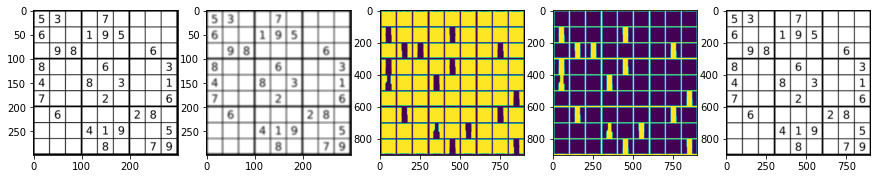

In [13]:
img = cv2.imread('examples/10.png')

# Finding a sudoku square
blurry = cv2.GaussianBlur(img, (5, 5), 5)
gray = cv2.cvtColor(blurry, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
grabs = imutils.grab_contours(cnts)
grabs = sorted(grabs, key=cv2.contourArea, reverse=True)[:15]
location = None
for grab in grabs:
    approx = cv2.approxPolyDP(grab, 15, True)
    if len(approx) == 4:
        location = approx
        break

height = 900
width = 900
pts1 = np.float32([location[0], location[3], location[1], location[2]])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
board = cv2.warpPerspective(img, matrix, (width, height))

# Filter out all numbers and noise to isolate only boxes
resgr = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(resgr, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

# Sort by top to bottom and each row by left to right
invert = 255 - thresh
cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []

# Iterate through each box
tesser = []

for row in sudoku_rows:
    for c in row:
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(img, mask)
        result[mask==0] = 255

fig, ax = plt.subplots(1, 5, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(blurry)
ax[2].imshow(invert)
ax[3].imshow(thresh)
ax[4].imshow(board)


,1,2,3,4,5,6,7,8,9
1,5,3,NaN,NaN,7,NaN,NaN,NaN,NaN
2,6,NaN,NaN,1,9,5,NaN,NaN,NaN
3,NaN,9,8,NaN,NaN,NaN,NaN,6,NaN
4,8,NaN,NaN,NaN,6,NaN,NaN,NaN,3
5,4,NaN,NaN,8,NaN,3,NaN,NaN,1
6,7,NaN,NaN,NaN,2,NaN,NaN,NaN,6
7,NaN,6,NaN,NaN,NaN,NaN,2,8,NaN
8,NaN,NaN,NaN,4,1,9,NaN,NaN,5
9,NaN,NaN,NaN,NaN,8,NaN,NaN,7,9


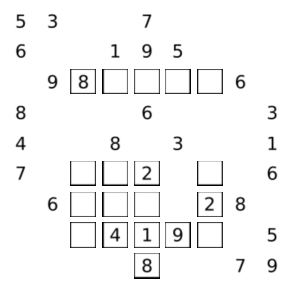

In [14]:
df_final = pd.DataFrame(index=range(1, 10), columns=range(1, 10))

fig, ax = plt.subplots(9, 9, figsize=(5,5))
split = np.split(board, 9, axis=1)
plmat = []
for col,j  in enumerate(split):
    digs = np.split(j, 9)
    for row,d in enumerate(digs):
        g = d.copy()
        e = d.copy()

        g = cv2.GaussianBlur(g, (5,5), 5)
        g = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
        g = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)
        center = np.array(g.shape) / 2
        center = tuple(center.astype('int32'))
        cv2.circle(g, center, 25, (255, 255, 255), 1)
        cn = cv2.findContours(g, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        grs = imutils.grab_contours(cn)
        grs = sorted(grs, key=cv2.contourArea, reverse=True)[:1]

        msk = np.zeros(e.shape, dtype=np.uint8)
        cv2.drawContours(msk, grs, -1, (255,255,255), -1)
        rst = cv2.bitwise_and(e, msk)
        rst[msk==0] = 255

        ax[row][col].imshow(rst)
        ax[row][col].axis('off')
        text = pytesseract.image_to_string(rst, config='--psm 10 digits')
        plmat.append([text, str(row+1), str(col+1)])
        df_final.iloc[row, col] = text
        
df_final.fillna('', inplace=True)
df_final = df_final.applymap(lambda x: x[:x.find('\n')])
df_final = df_final.applymap(lambda x: ''.join(re.findall('[1-9]', x)))
df_final = df_final[~(df_final=='')]

df_final

## Pulp

In [15]:
nums = [*map(str, [*range(1,10)])]
rows = nums
cols = nums
vals = nums

choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)

In [16]:
prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # Задаётся нулём, так как нас интересует только подбор значения согласно ограничениям

In [17]:
for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

In [18]:
grid = range(3)
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(grid, grid)] for i,j in product(grid, grid)]

for v,b in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in b]) == 1, ""

In [19]:
for i in plmat:
    i[0] = ''.join(re.findall('[\d]', i[0]))

sudoku_map = plmat.copy()
for i in plmat:
    if i[0] == '':
        sudoku_map.remove(i)
for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

In [20]:
prob.solve()
print("Status:", LpStatus[prob.status])
print("Solution:")
for r in rows:
    if r == "1" or r == "4" or r == "7":
        print("+-------+-------+-------+")
    for c,v in product(cols,vals):
        if choices[v][r][c].value() == 1:
            if c == "1" or c == "4" or c =="7":
                print("|", end=' ')
            print(v, end=' ')
            if c == "9":
                print("|")
print("+-------+-------+-------+")                    


Status: Optimal
Solution:
+-------+-------+-------+
| 5 3 4 | 6 7 8 | 9 1 2 |
| 6 7 2 | 1 9 5 | 3 4 8 |
| 1 9 8 | 3 4 2 | 5 6 7 |
+-------+-------+-------+
| 8 5 9 | 7 6 1 | 4 2 3 |
| 4 2 6 | 8 5 3 | 7 9 1 |
| 7 1 3 | 9 2 4 | 8 5 6 |
+-------+-------+-------+
| 9 6 1 | 5 3 7 | 2 8 4 |
| 2 8 7 | 4 1 9 | 6 3 5 |
| 3 4 5 | 2 8 6 | 1 7 9 |
+-------+-------+-------+


In [21]:
choices['9']['1']['1'].value()

0.0

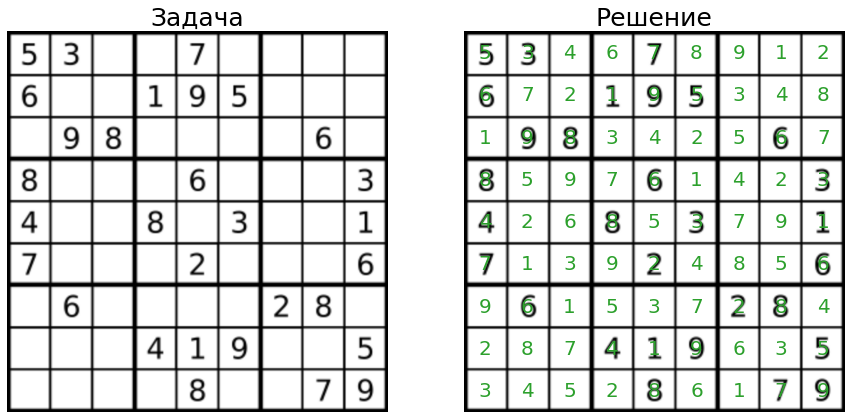

In [35]:
fig, axes = plt.subplots(1,2, figsize=(15,15))
axes[0].imshow(board)
axes[0].set_title('Задача', fontsize=25)
axes[1].imshow(board)
axes[1].set_title('Решение', fontsize=25)
for a in axes:
    a.axis('off')

y = 50
for r in rows:
    x = 50
    for c,v in product(cols, vals):
        if choices[v][r][c].value() == 1:
            axes[1].text(x,y,v, ha='center', va='center', fontsize=20, color='tab:green')
            x += 100
    y += 100
